In [1]:
import os
import pyspark
import plotly.graph_objects as go
from datetime import datetime
import pandas as pd
# Imports for plotting Map
import numpy as np
import seaborn as sns
from folium import plugins
%matplotlib inline
import folium
import plotly.express as px
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

plt.style.use('seaborn')
conf = pyspark.SparkConf()
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 22:35:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


# Exploratory Data Analysis 

In [2]:
from pyspark.sql.functions import *
df=spark.read.option("inferSchema","true").option("header","true").csv("Big_Data_Project/*.csv")
print(df.columns)
df.count()
df.dtypes

['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date', 'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2', 'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude', 'geo_precision', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3']


[('data_id', 'int'),
 ('iso', 'int'),
 ('event_id_cnty', 'string'),
 ('event_id_no_cnty', 'double'),
 ('event_date', 'string'),
 ('year', 'int'),
 ('time_precision', 'int'),
 ('event_type', 'string'),
 ('sub_event_type', 'string'),
 ('actor1', 'string'),
 ('assoc_actor_1', 'string'),
 ('inter1', 'int'),
 ('actor2', 'string'),
 ('assoc_actor_2', 'string'),
 ('inter2', 'int'),
 ('interaction', 'int'),
 ('region', 'string'),
 ('country', 'string'),
 ('admin1', 'string'),
 ('admin2', 'string'),
 ('admin3', 'string'),
 ('location', 'string'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('geo_precision', 'int'),
 ('source', 'string'),
 ('source_scale', 'string'),
 ('notes', 'string'),
 ('fatalities', 'int'),
 ('timestamp', 'int'),
 ('iso3', 'string')]

In [3]:
print((df.count(), len(df.columns)))

(1315502, 31)


In [4]:
df.select('fatalities').describe().show()
cnts = df.groupBy("year").count()

mode = cnts.join(
    cnts.agg(max("count").alias("max_")), col("count") == col("max_")
).limit(1).select("year")
mode.show()
cnts.show()
country = df.groupBy("country").count().sort(desc("count"))
country.show()

+-------+------------------+
|summary|        fatalities|
+-------+------------------+
|  count|           1315502|
|   mean|0.8352104367762269|
| stddev| 4.822280616611522|
|    min|                 0|
|    max|               750|
+-------+------------------+



+----+
|year|
+----+
|2021|
+----+



+----+------+
|year| count|
+----+------+
|2018|198200|
|2022| 84473|
|2019|215689|
|2020|249360|
|2021|266737|
|2015| 34410|
|2016| 72602|
|2017|111328|
|2013| 24750|
|2014| 22068|
|2012| 20280|
|2011| 15605|
+----+------+



+-------------+------+
|      country| count|
+-------------+------+
|        India|109649|
|        Syria| 98555|
|        Yemen| 72361|
|     Pakistan| 68127|
|  Afghanistan| 62406|
|       Mexico| 59259|
|      Ukraine| 56054|
|       Brazil| 52827|
|United States| 41118|
|         Iraq| 37053|
|      Myanmar| 32362|
|      Somalia| 29392|
|       Turkey| 24726|
|  South Korea| 22347|
|      Nigeria| 21372|
|   Bangladesh| 19054|
|         Iran| 18135|
|   Azerbaijan| 17554|
|       France| 16900|
|        Nepal| 16066|
+-------------+------+
only showing top 20 rows



In [5]:
ukraine=df[df["country"]=='Ukraine']
yemen=df[df["country"]=='Yemen']
syria=df[df["country"]=='Syria']


ukraine.select('fatalities').describe().show()
cnts = ukraine.groupBy("year").count()

mode = cnts.join(
    cnts.agg(max("count").alias("max_")), col("count") == col("max_")
).limit(1).select("year")
mode.show()
cnts.show()

yemen.select('fatalities').describe().show()
cnts = yemen.groupBy("year").count()

mode = cnts.join(
    cnts.agg(max("count").alias("max_")), col("count") == col("max_")
).limit(1).select("year")
mode.show()
cnts.show()

syria.select('fatalities').describe().show()
cnts = syria.groupBy("year").count()

mode = cnts.join(
    cnts.agg(max("count").alias("max_")), col("count") == col("max_")
).limit(1).select("year")
mode.show()
cnts.show()

+-------+-------------------+
|summary|         fatalities|
+-------+-------------------+
|  count|              56054|
|   mean|0.13866985406929033|
| stddev| 2.9454968468395855|
|    min|                  0|
|    max|                345|
+-------+-------------------+



+----+
|year|
+----+
|2019|
+----+



+----+-----+
|year|count|
+----+-----+
|2018|15192|
|2022| 5748|
|2019|16556|
|2020| 9937|
|2021| 8621|
+----+-----+



+-------+------------------+
|summary|        fatalities|
+-------+------------------+
|  count|             72361|
|   mean|2.1543372811321015|
| stddev| 5.072934557579858|
|    min|                 0|
|    max|               150|
+-------+------------------+



+----+
|year|
+----+
|2020|
+----+



+----+-----+
|year|count|
+----+-----+
|2018|11484|
|2022| 2640|
|2019|11875|
|2020|11914|
|2021| 8788|
|2015| 8058|
|2016| 9079|
|2017| 8523|
+----+-----+



+-------+------------------+
|summary|        fatalities|
+-------+------------------+
|  count|             98555|
|   mean|1.1760539800111613|
| stddev|4.5570482990370715|
|    min|                 0|
|    max|               469|
+-------+------------------+



+----+
|year|
+----+
|2017|
+----+



+----+-----+
|year|count|
+----+-----+
|2018|20943|
|2022| 2923|
|2019|20094|
|2020|12417|
|2021|10730|
|2017|31448|
+----+-----+



In [6]:
evts=yemen.groupBy("event_type").count()
evts.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Explosions/Remote...|41965|
|Violence against ...| 2900|
|Strategic develop...| 3798|
|            Protests| 2642|
|               Riots|  367|
|             Battles|20689|
+--------------------+-----+



In [7]:
df.stat.crosstab("region", "event_type").show()

+--------------------+-------+--------------------------+--------+-----+----------------------+--------------------------+
|   region_event_type|Battles|Explosions/Remote violence|Protests|Riots|Strategic developments|Violence against civilians|
+--------------------+-------+--------------------------+--------+-----+----------------------+--------------------------+
|           East Asia|      7|                        10|   40461|  834|                  1730|                      1724|
|     Northern Africa|   8538|                      6972|   28439| 5220|                  2470|                      6981|
|             Oceania|     29|                         0|    1482|  119|                    96|                        30|
|       North America|   5964|                        63|   63686| 4592|                  3665|                     24956|
|          South Asia|  11456|                      6654|  155678|30193|                  3263|                     11235|
|      Western A

In [8]:
df.describe().show()

+-------+------------------+-----------------+-------------+------------------+---------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+--------------+-----------+-------+-------------+-------------+--------------+------------------+-----------------+------------------+-------------+--------------------+--------------------+------------------+--------------------+-------+
|summary|           data_id|              iso|event_id_cnty|  event_id_no_cnty|     event_date|              year|     time_precision|          event_type|      sub_event_type|              actor1|       assoc_actor_1|            inter1|              actor2|       assoc_actor_2|            inter2|       interaction|        region|    country| admin1|       admin2|       admin3|      location|          latitude|        longitude|     geo_pre

22/05/17 22:39:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:

df_region = df.groupBy("region").count()
df_region = df_region.na.drop(subset=["region"])
region = df_region.select(collect_list('region')).first()[0] 
regionCount = df_region.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = region , values = regionCount)],
    layout_title_text="Region vs Count of  Armed Conflict Events"
)
fig.show()

In [10]:
df_event_type = df.groupBy("event_type").count()
eventType = df_event_type.select(collect_list('event_type')).first()[0] 
eventTypeCount = df_event_type.select(collect_list('count')).first()[0]
fig1 = go.Figure(
    data=[go.Bar(x = eventType , y = eventTypeCount)],
    layout_title_text="Event Type vs Count of  Armed Conflict Events"
)
fig1.show()

In [11]:
europe=df[df["region"]=='Europe']
europeCountry = europe.groupBy("country").count()
europeCountry = europeCountry.sort(col('count').desc())
eu = europeCountry.select(collect_list('country')).first()[0] 
euCount = europeCountry.select(collect_list('count')).first()[0]

fig3 = go.Figure(
    data=[go.Bar(x = eu , y = euCount)],
    layout_title_text="European Country vs Count of  Armed Conflict Events"
)
fig3.show()

In [12]:
SAsia=df[df["region"]=='South Asia']
SAsiaCountry = SAsia.groupBy("country").count()
SAsiaCountry = SAsiaCountry.sort(col('count').desc())
SA = SAsiaCountry.select(collect_list('country')).first()[0] 
SACount = SAsiaCountry.select(collect_list('count')).first()[0]

fig3 = go.Figure(
    data=[go.Bar(x = SA , y = SACount)],
    layout_title_text="South Asian Country vs Count of  Armed Conflict Events"
)
fig3.show()

# Ukraine Usecase

In [13]:

airbase=spark.read.option("inferSchema","true").option("header","true").csv("airbase.csv")
#airbase = airbase.na.drop()


In [14]:
ukraine=df[df["country"]=='Ukraine']
ukraine=ukraine[ukraine["year"]==2022]
events=np.array(ukraine.select('latitude','longitude').collect())
airbases=np.array(airbase.select('latitude','longitude').collect())
trailmap= folium.Map([50.4501, 30.5234], zoom_start=11,tiles ='Stamen Toner')

plugins.MarkerCluster(airbases).add_to(trailmap)
trailmap.add_children(plugins.HeatMap(events, radius=15))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [15]:
trailmap.save('ukraine1.html')

In [16]:

airbase=airbase[airbase["use"]=="Military"]
ukraine=df[df["country"]=='Ukraine']
ukraine=ukraine[ukraine["year"]==2022]
events=np.array(ukraine.select('latitude','longitude').collect())
airbases=np.array(airbase.select('latitude','longitude').collect())
trailmap= folium.Map([50.4501, 30.5234], zoom_start=11,tiles ='Stamen Toner')
plugins.MarkerCluster(airbases).add_to(trailmap)
trailmap.add_children(plugins.HeatMap(events, radius=15))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [17]:
trailmap.save('ukraine2.html')

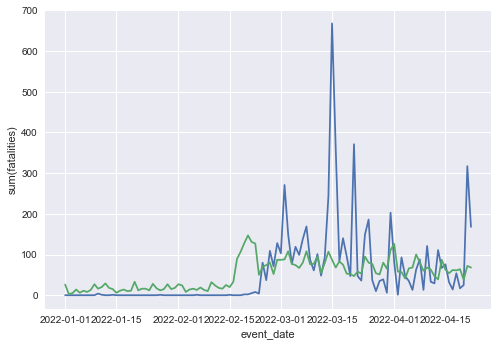

In [18]:

fatalities_per_day = ukraine.select('year','event_date','fatalities')\
                                    .where("year=2022")\
                                    .groupBy('event_date')\
                                    .agg({'fatalities':'sum','event_date':'count'})\
                                    .orderBy('sum(fatalities)',ascending=False)
df1 = fatalities_per_day.toPandas() 
df1['event_date'] = pd.to_datetime(df1['event_date'])
df1['sum(fatalities)'] = [int(x) for x in df1['sum(fatalities)']]


sns.lineplot(x="event_date", y="sum(fatalities)", data=df1)
sns.lineplot(x="event_date", y="count(event_date)",data=df1)
sns.set(rc={'figure.figsize':(15,15)})



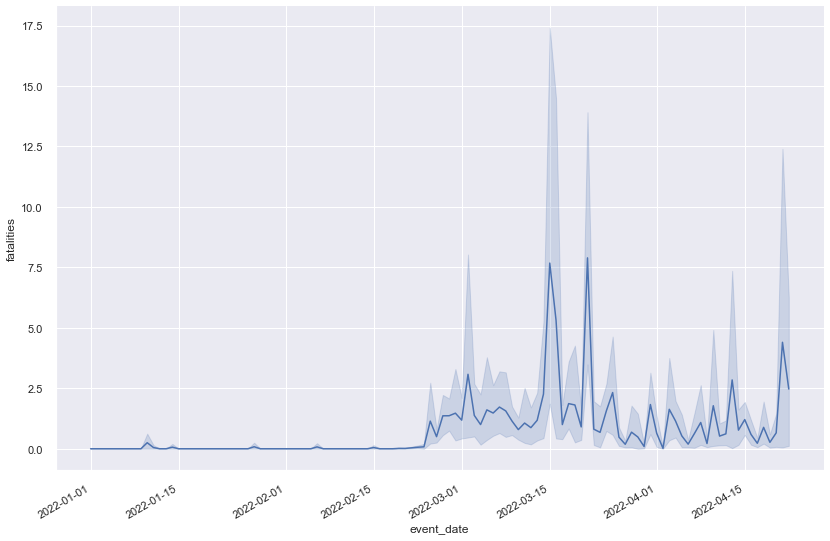

In [19]:
ukrainedf=ukraine.toPandas()
ukrainedf['event_date'] = pd.to_datetime(ukrainedf['event_date'])
g = sns.relplot(x="event_date", y="fatalities", kind="line", data=ukrainedf,height=8.27, aspect=11.7/8.27)
sns.set(rc={'figure.figsize':(25,25)})
g.figure.autofmt_xdate()

<AxesSubplot:xlabel='event_date', ylabel='fatalities'>

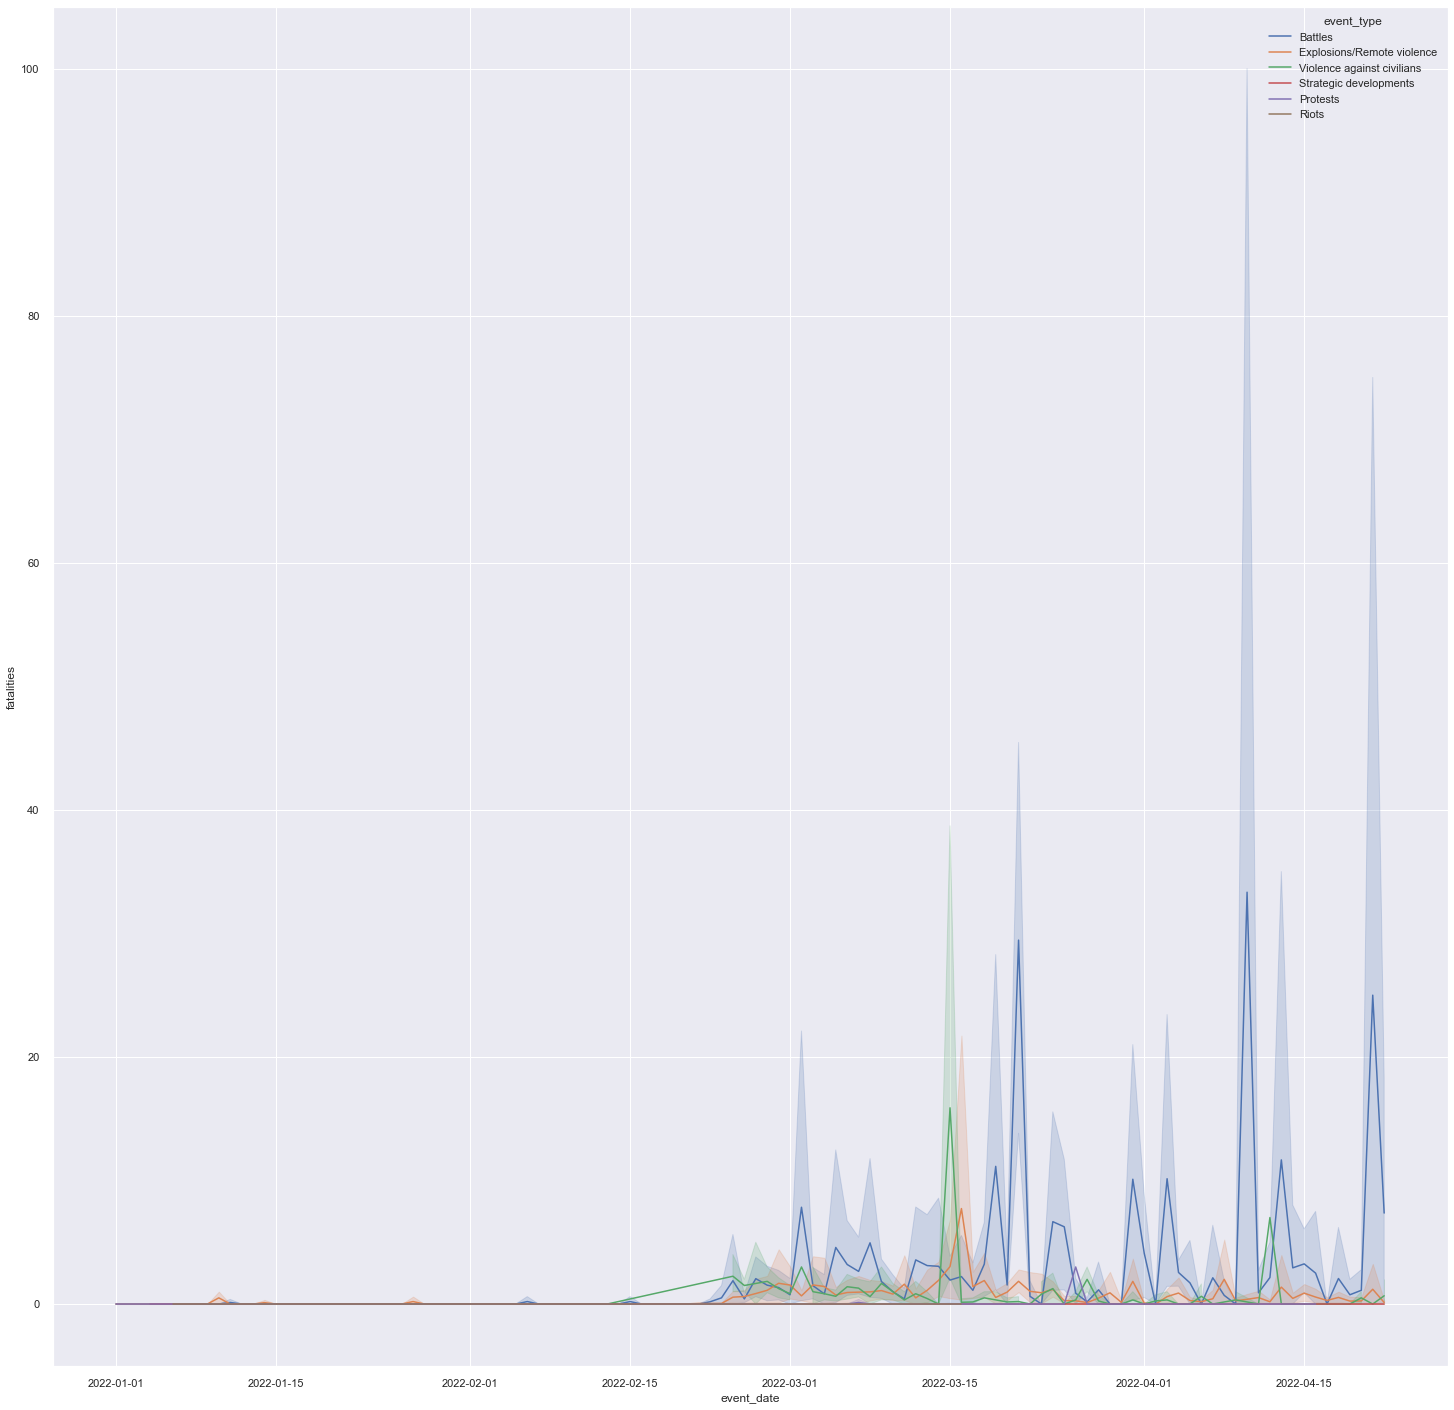

In [20]:
data=ukraine.toPandas()
data['event_date'] = pd.to_datetime(data['event_date'])
data=data[data["year"]==2022]
sns.lineplot(x ="event_date",
             y ="fatalities",
             hue ="event_type",
             
             data = data)

In [21]:



fig = px.scatter(data, x="event_date", y="fatalities",size="fatalities", color="event_type",
                 hover_name="actor1", size_max=30)
fig.show()

In [22]:
df.dtypes

[('data_id', 'int'),
 ('iso', 'int'),
 ('event_id_cnty', 'string'),
 ('event_id_no_cnty', 'double'),
 ('event_date', 'string'),
 ('year', 'int'),
 ('time_precision', 'int'),
 ('event_type', 'string'),
 ('sub_event_type', 'string'),
 ('actor1', 'string'),
 ('assoc_actor_1', 'string'),
 ('inter1', 'int'),
 ('actor2', 'string'),
 ('assoc_actor_2', 'string'),
 ('inter2', 'int'),
 ('interaction', 'int'),
 ('region', 'string'),
 ('country', 'string'),
 ('admin1', 'string'),
 ('admin2', 'string'),
 ('admin3', 'string'),
 ('location', 'string'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('geo_precision', 'int'),
 ('source', 'string'),
 ('source_scale', 'string'),
 ('notes', 'string'),
 ('fatalities', 'int'),
 ('timestamp', 'int'),
 ('iso3', 'string')]

# CLUSTERING

In [23]:


ukraine=df[df['country']=='Ukraine']
indexer= StringIndexer(inputCol='actor1',outputCol='actor1_idx')
indexer=indexer.fit(ukraine)
ukraine=indexer.transform(ukraine)
ukraine=StringIndexer(inputCol='event_type',outputCol='event_type_idx').fit(ukraine).transform(ukraine)
ukraine=StringIndexer(inputCol='source_scale',outputCol='source_scale_type_idx').fit(ukraine).transform(ukraine)


assembler=VectorAssembler(inputCols=['actor1_idx','event_type_idx','source_scale_type_idx','interaction','fatalities'],outputCol='features')
ukraine=assembler.transform(ukraine)


scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(ukraine)
ukraine=data_scale.transform(ukraine)


silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,6):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(ukraine)
    output=KMeans_fit.transform(ukraine)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)




















Silhouette Score: 0.7418005970619237


Silhouette Score: 0.7357135672818502


Silhouette Score: 0.7734244571461113


Silhouette Score: 0.7782161717715629


In [24]:
model=KMeans(featuresCol='standardized',k=5)
KMeans_fit=model.fit(ukraine)
output=KMeans_fit.transform(ukraine)
output.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1396|
|         3| 6831|
|         4|  220|
|         2| 3799|
|         0|43808|
+----------+-----+



In [25]:
group0=output[output["prediction"]==0]
group0.groupby('event_type').count().show()
group0.groupby('actor1').count().show()
group0.select('fatalities').summary("count", "min", "25%", "75%", "max").show()

group0_actor = group0.groupBy("actor1").count()
group0_actor = group0_actor.na.drop(subset=["actor1"])
actor = group0_actor.select(collect_list('actor1')).first()[0] 
actorCount = group0_actor.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = actor , values = actorCount)],
    layout_title_text="Cluster 0 Actor Share"
)
fig.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Explosions/Remote...|23006|
|Strategic develop...|   29|
|            Protests|   43|
|             Battles|20730|
+--------------------+-----+



+--------------------+-----+
|              actor1|count|
+--------------------+-----+
|Military Forces o...|10514|
|Military Forces o...|   23|
|Military Forces o...|   20|
|Police Forces of ...|    2|
|Protesters (Ukraine)|   43|
|Military Forces o...|  692|
|Unidentified Arme...|  396|
|Military Forces o...|13121|
|Police Forces of ...|    1|
|NAF: United Armed...|18996|
+--------------------+-----+



+-------+----------+
|summary|fatalities|
+-------+----------+
|  count|     43808|
|    min|         0|
|    25%|         0|
|    75%|         0|
|    max|        20|
+-------+----------+



In [26]:
group1=output[output["prediction"]==1]
group1.groupby('event_type').count().show()
group1.groupby('actor1').count().show()
group1.select('fatalities').summary("count", "min", "25%", "75%", "max").show()



group1_actor = group1.groupBy("actor1").count()
group1_actor = group1_actor.na.drop(subset=["actor1"])
actor = group1_actor.select(collect_list('actor1')).first()[0] 
actorCount = group1_actor.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = actor , values = actorCount)],
    layout_title_text="Cluster 1 Actor Share"
)
fig.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Explosions/Remote...| 1355|
|Violence against ...|    2|
|             Battles|   39|
+--------------------+-----+



+--------------------+-----+
|              actor1|count|
+--------------------+-----+
|Military Forces o...|    3|
|Military Forces o...|  127|
|Police Forces of ...|    1|
|Military Forces o...|   11|
|Military Forces o...| 1196|
|Unidentified Arme...|   33|
|Military Forces o...|   23|
|NAF: United Armed...|    2|
+--------------------+-----+



+-------+----------+
|summary|fatalities|
+-------+----------+
|  count|      1396|
|    min|         0|
|    25%|         0|
|    75%|         1|
|    max|       345|
+-------+----------+



In [27]:
group2=output[output["prediction"]==2]
group2.groupby('event_type').count().show()
group2.groupby('actor1').count().show()
group2.select('fatalities').summary("count", "min", "25%", "75%", "max").show()

group2_actor = group2.groupBy("actor1").count()
group2_actor = group2_actor.na.drop(subset=["actor1"])
actor = group2_actor.select(collect_list('actor1')).first()[0] 
actorCount = group2_actor.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = actor , values = actorCount)],
    layout_title_text="Clustur 2 Actor Share"
)
fig.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Explosions/Remote...|  773|
|Violence against ...|   46|
|Strategic develop...|  196|
|            Protests|  489|
|               Riots|   42|
|             Battles| 2253|
+--------------------+-----+



+--------------------+-----+
|              actor1|count|
+--------------------+-----+
|Military Forces o...| 1580|
|Military Forces o...|    1|
|Police Forces of ...|    2|
| Protesters (Russia)|    6|
|Military Forces o...|   16|
| Civilians (Ukraine)|    3|
|Police Forces of ...|    6|
|Protesters (Ukraine)|  483|
|Military Forces o...|    1|
|Police Forces of ...|   13|
|Military Forces o...|  138|
|Police Forces of ...|    8|
|   Rioters (Ukraine)|   42|
|Unidentified Arme...|  198|
|Military Forces o...|  101|
|Police Forces of ...|   18|
|NAF: United Armed...| 1183|
+--------------------+-----+



+-------+----------+
|summary|fatalities|
+-------+----------+
|  count|      3799|
|    min|         0|
|    25%|         0|
|    75%|         0|
|    max|        32|
+-------+----------+



In [28]:
group3=output[output["prediction"]==3]
group3.groupby('event_type').count().show()
group3.groupby('actor1').count().show()
group3.select('fatalities').summary("count", "min", "25%", "75%", "max").show()


group3_actor = group3.groupBy("actor1").count()
group3_actor = group3_actor.na.drop(subset=["actor1"])
actor = group3_actor.select(collect_list('actor1')).first()[0] 
actorCount = group3_actor.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = actor , values = actorCount)],
    layout_title_text="Cluster 3 Actor Share"
)
fig.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Violence against ...|  506|
|Strategic develop...|  970|
|            Protests| 4972|
|               Riots|  374|
|             Battles|    9|
+--------------------+-----+



+--------------------+-----+
|              actor1|count|
+--------------------+-----+
|Donetsk People's ...|   19|
|Military Forces o...|  133|
|Military Forces o...|   13|
|Police Forces of ...|   15|
| Protesters (Russia)|   11|
|Military Forces o...|    2|
| Civilians (Ukraine)|  208|
|Police Forces of ...|   49|
|Protesters (Ukraine)| 4958|
|Protesters (Belarus)|    3|
|Military Forces o...|    5|
|Police Forces of ...|   33|
|Military Forces o...|  315|
|Police Forces of ...|   25|
|   Rioters (Ukraine)|  374|
|Unidentified Arme...|  355|
|Military Forces o...|  143|
|Police Forces of ...|   59|
|NAF: United Armed...|  111|
+--------------------+-----+



+-------+----------+
|summary|fatalities|
+-------+----------+
|  count|      6831|
|    min|         0|
|    25%|         0|
|    75%|         0|
|    max|        20|
+-------+----------+



In [29]:
group4=output[output["prediction"]==4]
group4.groupby('event_type').count().show()
group4.groupby('actor1').count().show()
group4.select('fatalities').summary("count", "min", "25%", "75%", "max").show()


group4_actor = group4.groupBy("actor1").count()
group4_actor = group4_actor.na.drop(subset=["actor1"])
actor = group4_actor.select(collect_list('actor1')).first()[0] 
actorCount = group3_actor.select(collect_list('count')).first()[0]
fig = go.Figure(
    data=[go.Pie(labels = actor , values = actorCount)],
    layout_title_text="Cluster 4 Actor Share"
)
fig.show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|Explosions/Remote...|   16|
|Violence against ...|   49|
|Strategic develop...|  101|
|            Protests|   23|
|               Riots|    2|
|             Battles|   29|
+--------------------+-----+



+--------------------+-----+
|              actor1|count|
+--------------------+-----+
|Military Forces o...|   11|
|Unidentified Arme...|    5|
|Military Forces o...|    1|
|Sentianivka Commu...|    1|
|Police Forces of ...|    3|
|Unidentified Mili...|    6|
|National Corps Party|    4|
|Government of Ukr...|   11|
|Donetsk People's ...|    5|
|    Rioters (Greece)|    1|
|Opposition Platfo...|    1|
|Government of Ukr...|   14|
|Police Forces of ...|    4|
|    Fatherland Party|    1|
|Bucha Communal Mi...|    1|
|Police Forces of ...|   15|
|Luhansk People's ...|    3|
|   Cossacks (Russia)|    1|
|Protesters (Inter...|    8|
|Unidentified Arme...|    1|
+--------------------+-----+
only showing top 20 rows



+-------+----------+
|summary|fatalities|
+-------+----------+
|  count|       220|
|    min|         0|
|    25%|         0|
|    75%|         0|
|    max|       100|
+-------+----------+



# AFGHANISTAN USECASE

In [30]:
afghan=df[df["country"]=='Afghanistan']
#afghan=afghan[afghan["year"]>=2019]
events=np.array(afghan.select('latitude','longitude').collect())
events





array([[34.9874, 63.1289],
       [34.5167, 69.1833],
       [35.7259, 64.2416],
       ...,
       [34.8714, 62.5483],
       [34.5897, 69.7625],
       [32.6542, 62.1043]])

In [31]:
trailmap= folium.Map([34.555, 69.20], zoom_start=11,tiles ='OpenStreetMap')


trailmap.add_children(plugins.HeatMap(events, radius=15))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [32]:
trailmap.save('Afghanistan1.html')

In [33]:
trailmap= folium.Map([34.555, 69.20], zoom_start=11,tiles ='Stamen Terrain')


trailmap.add_children(plugins.HeatMap(events, radius=15))



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [34]:
trailmap.save('Afghanistan2.html')

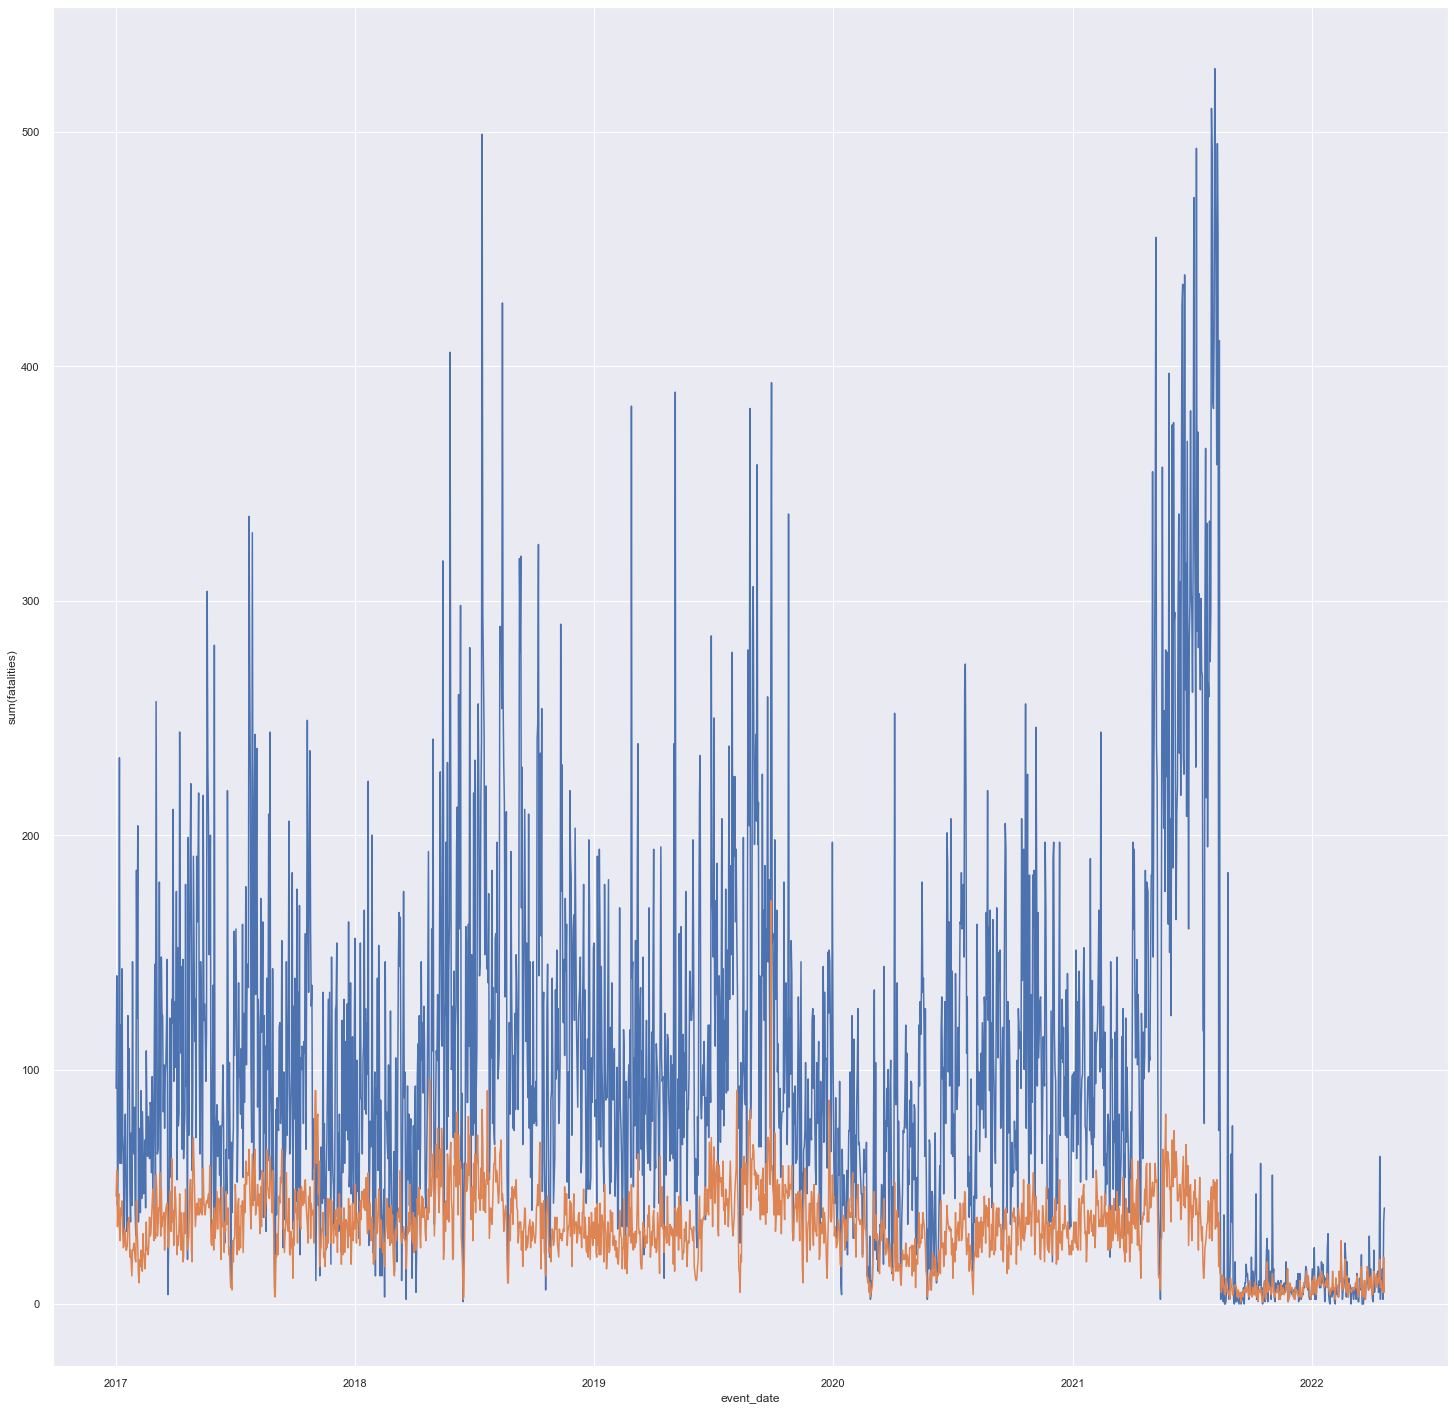

In [35]:

fatalities_per_day = afghan.select('year','event_date','fatalities')\
                                    .groupBy('event_date')\
                                    .agg({'fatalities':'sum','event_date':'count'})\
                                    .orderBy('sum(fatalities)',ascending=False)
df2 = fatalities_per_day.toPandas() 
df2['event_date'] = pd.to_datetime(df2['event_date'])
df2['sum(fatalities)'] = [int(x) for x in df2['sum(fatalities)']]


sns.lineplot(x="event_date", y="sum(fatalities)", data=df2)
sns.lineplot(x="event_date", y="count(event_date)",data=df2)
sns.set(rc={'figure.figsize':(7,7)})



In [36]:

indexer= StringIndexer(inputCol='actor1',outputCol='actor1_idx')
indexer=indexer.fit(afghan)
afghan=indexer.transform(afghan)



afghan=StringIndexer(inputCol='event_type',outputCol='event_type_idx').fit(afghan).transform(afghan)
afghan=StringIndexer(inputCol='source_scale',outputCol='source_scale_type_idx').fit(afghan).transform(afghan)
afghan=StringIndexer(inputCol='sub_event_type',outputCol='sub_event_type_idx').fit(afghan).transform(afghan)
afghan=StringIndexer(inputCol='admin1',outputCol='admin1_idx').fit(afghan).transform(afghan)




assembler=VectorAssembler(inputCols=['actor1_idx','inter1','inter2','event_type_idx','admin1_idx','sub_event_type_idx','source_scale_type_idx'],outputCol='features')
afghan=assembler.transform(afghan)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(afghan)
afghan=data_scale.transform(afghan)

In [37]:
from pyspark.ml.regression import LinearRegression
train=afghan[afghan["year"]<=2020]
test=afghan[afghan["year"]>=2021].sample(False, 0.1, seed=0).limit(20)
#train,test = afghan.randomSplit([0.75, 0.25])
lin_reg = LinearRegression(featuresCol = 'standardized', labelCol='fatalities',maxIter=1000,regParam=0.4,
                           loss='squaredError', elasticNetParam=0.9)
linear_model = lin_reg.fit(train)
print("Coefficients: " + str(linear_model.coefficients))
print("\nIntercept: " + str(linear_model.intercept))

22/05/17 22:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/17 22:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Coefficients: [0.10411981127244051,-0.4447870584657356,0.0,-0.20116656655480042,0.0,0.0,1.5288596912959205]

Intercept: 3.0771888836816106


In [38]:
trainSummary = linear_model.summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
print("\nr2: %f" % trainSummary.r2)


RMSE: 6.089464

r2: 0.080982


In [39]:
from  pyspark.sql.functions import abs
predictions = linear_model.transform(test)
predictions=predictions[predictions["prediction"]>=0]
predictions.select("prediction","fatalities","features").show()


+------------------+----------+--------------------+
|        prediction|fatalities|            features|
+------------------+----------+--------------------+
| 7.665947240819182|         4|[2.0,3.0,1.0,0.0,...|
| 4.260148489269746|         1|[45.0,2.0,1.0,0.0...|
| 8.886408261596689|         0|[10.0,2.0,1.0,0.0...|
| 8.743165482488832|         1|[5.0,2.0,1.0,0.0,...|
|2.1803750549449408|         2|[2.0,3.0,7.0,2.0,...|
|2.0198376678795684|        15|[30.0,8.0,7.0,1.0...|
| 3.083931710266037|         0|[8.0,1.0,7.0,2.0,...|
| 3.515286037908896|         2|[19.0,2.0,1.0,0.0...|
| 4.191424498076552|         1|[8.0,1.0,2.0,0.0,...|
|  3.88288894952386|         2|[10.0,2.0,1.0,0.0...|
| 3.257449035514756|         3|[10.0,2.0,1.0,0.0...|
| 9.144245263990829|         0|[19.0,2.0,1.0,0.0...|
| 8.260968347587585|         0|[10.0,2.0,1.0,0.0...|
| 8.886408261596689|         0|[10.0,2.0,1.0,0.0...|
|3.5659845840674484|         3|[8.0,1.0,2.0,0.0,...|
|2.4214014918456463|         2|[2.0,3.0,7.0,1.

In [40]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol = 'standardized', labelCol = 'fatalities')
dt_model = dt.fit(train)


In [41]:
dt_predictions = dt_model.transform(test)
dt_predictions.select('prediction', 'fatalities', 'features').show(20)



+------------------+----------+--------------------+
|        prediction|fatalities|            features|
+------------------+----------+--------------------+
|  7.81058495821727|         4|[2.0,3.0,1.0,0.0,...|
|5.2774266365688485|         1|[45.0,2.0,1.0,0.0...|
|  7.81058495821727|         0|[10.0,2.0,1.0,0.0...|
|  7.81058495821727|         1|[5.0,2.0,1.0,0.0,...|
| 1.901749663526245|         2|[2.0,3.0,7.0,2.0,...|
| 3.180058651026393|        15|[30.0,8.0,7.0,1.0...|
|1.5217391304347827|         0|[8.0,1.0,7.0,2.0,...|
|5.2774266365688485|         2|[19.0,2.0,1.0,0.0...|
| 7.467296844031102|         1|[8.0,1.0,2.0,0.0,...|
|5.2774266365688485|         2|[10.0,2.0,1.0,0.0...|
|5.2774266365688485|         3|[10.0,2.0,1.0,0.0...|
|  7.81058495821727|         0|[19.0,2.0,1.0,0.0...|
|  7.81058495821727|         0|[10.0,2.0,1.0,0.0...|
|  7.81058495821727|         0|[10.0,2.0,1.0,0.0...|
| 7.467296844031102|         3|[8.0,1.0,2.0,0.0,...|
| 3.180058651026393|         2|[2.0,3.0,7.0,1.

In [42]:
from pyspark.ml.regression import FMRegressor
fm = FMRegressor(featuresCol="standardized",labelCol = 'fatalities', stepSize=0.001)
fm_model=fm.fit(train)



In [43]:

fm_predictions = fm_model.transform(test)
fm_predictions.select('prediction', 'fatalities', 'features').show(20)

+------------------+----------+--------------------+
|        prediction|fatalities|            features|
+------------------+----------+--------------------+
|3.9503235384566477|         4|[2.0,3.0,1.0,0.0,...|
| 5.747898663435883|         1|[45.0,2.0,1.0,0.0...|
|4.6329484517012816|         0|[10.0,2.0,1.0,0.0...|
| 4.432971851140112|         1|[5.0,2.0,1.0,0.0,...|
|2.6993234504928876|         2|[2.0,3.0,7.0,2.0,...|
|12.966410994022004|        15|[30.0,8.0,7.0,1.0...|
| 2.983759786339716|         0|[8.0,1.0,7.0,2.0,...|
| 3.775283606477125|         2|[19.0,2.0,1.0,0.0...|
| 2.561761563412152|         1|[8.0,1.0,2.0,0.0,...|
| 2.664618312107695|         2|[10.0,2.0,1.0,0.0...|
|1.9827579258134502|         3|[10.0,2.0,1.0,0.0...|
| 7.193160572816698|         0|[19.0,2.0,1.0,0.0...|
| 6.031719239694587|         0|[10.0,2.0,1.0,0.0...|
|4.6329484517012816|         0|[10.0,2.0,1.0,0.0...|
|2.5462668608400936|         3|[8.0,1.0,2.0,0.0,...|
| 4.201746036042706|         2|[2.0,3.0,7.0,1.

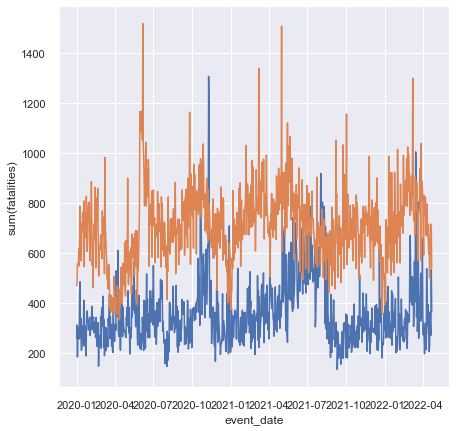

In [44]:

fatalities_per_day = df.select('year','event_date','fatalities')\
                                    .where("year>=2020")\
                                    .groupBy('event_date')\
                                    .agg({'fatalities':'sum','event_date':'count'})\
                                    .orderBy('sum(fatalities)',ascending=False)
df1 = fatalities_per_day.toPandas() 
df1['event_date'] = pd.to_datetime(df1['event_date'])
df1['sum(fatalities)'] = [int(x) for x in df1['sum(fatalities)']]


sns.lineplot(x="event_date", y="sum(fatalities)", data=df1)
sns.lineplot(x="event_date", y="count(event_date)",data=df1)
sns.set(rc={'figure.figsize':(30,30)})


